In [ ]:
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import random, vmap, jit, grad, jacfwd, jacrev
from jax.tree_util import tree_multimap
from jax.flatten_util import ravel_pytree
from jax.ops import index, index_add, index_update
from jax.scipy.stats import multivariate_normal, norm
from functools import partial
from jax.lax import while_loop
from jax.nn import sigmoid, log_sigmoid
import itertools
import numpy.random as npr
from tqdm import trange
from jax.experimental import optimizers
import jax.scipy.stats.norm as norm
from tqdm import tqdm, trange

### Problem 1

1) No. Use KL divergence of $\mathcal U(0,1), \mathcal U(0,2)$ as a counter example.


b) By Jensen's inequality on convex function $-\log$, 
\begin{align*}
        KL(p||q) &= -\int \log\left(\frac{q(x)}{p(x)}\right)dp\\
                 &\geq -\log\int\left(\frac{q(x)}{p(x)}\right)dp\\
                 &= -\log\int dq\\
                 &= -\log 1\\
                 &= 0,
\end{align*}
where $dp = p(x)dx, dq = q(x)dx$.


c) KL divergence is not a norm so many properties such as triangluar inequality can not be used to derive some inequality. It also need to extra redefinition of quantities such as $0\log (0/0) = 0$, which may not be compliant with the actual limit.


d) Cross entropy can be defined as
\begin{align*}
      H(p,q) &:= -\mathbb{E}_{x\sim p(x)}\left[\log(q(x))\right]
\end{align*}
while KL divergence can be defined as
\begin{align*}
      KL(p||q) &:= \mathbb{E}_{x\sim p(x)}\left[\frac{\log(p(x))}{\log(q(x))}\right]\\
               &= \mathbb{E}_{x\sim p(x)}\left[\log(p(x))-\log(q(x))\right]\\
               &= \mathbb{E}_{x\sim p(x)}\left[\log(p(x))\right] - \mathbb{E}_{x\sim p(x)}\left[\log(q(x))\right]\\
               &= \mathbb{E}_{x\sim p(x)}\left[\log(p(x))\right] + H(p,q).
\end{align*}

e) Optimizng cross entropy loss is equivalent to the optimization of the KL divergence between the model output and an empirical estimate of the actual distribution given the data.

### Problem 2

By Jensen's inequality on concave function $\log$,
\begin{align*}
    \log P(\mathcal D) &= \log \int p(\mathcal D|\theta)p(\theta)\frac{q(\theta|\mathcal D)}{q(\theta|\mathcal D)} d\theta\\
    &= \log \int \frac{p(\mathcal D|\theta)p(\theta)}{q(\theta|\mathcal D)}dq \\
    &\geq \int \log \frac{p(\mathcal D|\theta)p(\theta)}{q(\theta|\mathcal D)}dq\\
    &= \mathbb{E}_{q(\theta|\mathcal{D})}\left[\log\left(p(\theta)\right)\right]+\mathbb{E}_{q(\theta|\mathcal{D})}\left[\log(p(\mathcal{D}|\theta))\right]- \mathbb{E}_{q(\theta|\mathcal{D})}\left[\log(q(\theta|\mathcal{D}))\right],
\end{align*}
where $dq = q(\theta|\mathcal D)d\theta$.

b) When the KL divergence of these two distributions is zero, we have
\begin{align*}
        \mathbb{E}_{q(\theta|\mathcal{D})}\left[\log(q(\theta|\mathcal{D}))\right] &= \mathbb{E}_{q(\theta|\mathcal{D})}\left[\log(p(\theta|\mathcal{D}))\right]\\
              &= \mathbb{E}_{q(\theta|\mathcal{D})}\left[\log\left(\frac{p(\theta)p(\mathcal{D}|\theta)}{p(\mathcal{D})}\right)\right]\\
              &= \mathbb{E}_{q(\theta|\mathcal{D})}\left[\log\left(p(\theta)\right)\right]+\mathbb{E}_{q(\theta|\mathcal{D})}\left[\log(p(\mathcal{D}|\theta))\right] - \mathbb{E}_{q(\theta|\mathcal{D})}\left[\log(p(\mathcal{D}))\right]\\
              &= \mathbb{E}_{q(\theta|\mathcal{D})}\left[\log\left(p(\theta)\right)\right]+\mathbb{E}_{q(\theta|\mathcal{D})}\left[\log(p(\mathcal{D}|\theta))\right] - \log(p(\mathcal{D})),
\end{align*}
as desired.

### Problem 3

In [ ]:
# System Parameters
mu = np.zeros(2)
sigma = np.array([[1.,0.9],[0.9,1]])
alpha = 1.15
beta = 0.5

# Transformations
def transf_plus(point):
  a1, a2 = point
  x1 = alpha*a1
  return np.array([x1, a2/alpha + beta*(x1**2+alpha**2)])

def transf_minus(point):
  b1, b2 = point
  x2 = -(alpha*b1+3)
  return np.array([x2, b2/alpha -beta*(x2**2+alpha**2)+10])

# Data Generation
keys = random.split(random.PRNGKey(0))
size_data = 1000
data_plus = vmap(transf_plus)(random.multivariate_normal(keys[0], mu, sigma, (size_data,)))
data_minus = vmap(transf_minus)(random.multivariate_normal(keys[1], mu, sigma, (size_data,)))

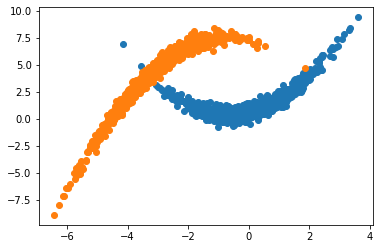

In [ ]:
plt.scatter(*data_plus.T)
plt.scatter(*data_minus.T)

In [ ]:
# Joining and Permuting Data
data = np.concatenate((data_plus, data_minus))
labels = np.concatenate((np.ones(size_data), np.zeros(size_data)))
key = random.PRNGKey(0)
data, labels = random.permutation(key, data), random.permutation(key, labels)

# Normalizing Data
original_mean = np.mean(data, axis=0)
original_std = np.std(data, axis=0)
data = (data-original_mean)/original_std

In [ ]:
opt_init, opt_update, get_params = optimizers.adam(1e-2)

In [ ]:
linear_forward = lambda params, X: (X @ params[0] + params[1]).reshape(-1)

def single_elbo(params, batch, rng_key):
    # params consists of tuples of means and log std
    mu, log_std = params
    X, y = batch
    flat_mu, unravel = ravel_pytree(mu)
    # flatten the list to tuple
    flat_log_std,_ = ravel_pytree(log_std)

    flat_par = flat_mu + np.exp(flat_log_std) * random.normal(rng_key, flat_mu.shape)
    w, b = unravel(flat_par)
    logit_prob = linear_forward((w, b), X)
    prob_pres = log_sigmoid(logit_prob)
    prob_abs = log_sigmoid(-logit_prob)
    log_likelihood = np.sum(y * prob_pres + (1 - y) * prob_abs)
    log_prior = np.sum(flat_par)
    entropy = -np.sum(flat_log_std)
    return entropy - (log_likelihood + log_prior) 
def elbo(params, batch, rng_key):
    # Average over a batch of random samples.
    rng_keyes = random.split(rng_key, 20)
    loss = vmap(single_elbo, in_axes=(None, None, 0))(params, batch, rng_keyes)

    return np.mean(loss)

@jit
def step(i, opt_state, batch, rng_key):
    params = get_params(opt_state)
    g = grad(elbo)(params, batch, rng_key)
    return opt_update(i, g, opt_state)

In [ ]:
batch = (data, labels)

In [ ]:
opt_state = opt_init(((np.array((0.,0.)), 0.), (np.array((0.,0.)), 0.)))
pbar = trange(5000)
for i in pbar:
    rng_key = random.PRNGKey(i)
    opt_state = step(i, opt_state, batch, rng_key)

    if i % 50 == 0:
        loss_value = elbo(get_params(opt_state), batch, random.PRNGKey(0))
        pbar.set_postfix({'Loss': loss_value})



100%|██████████| 5000/5000 [00:17<00:00, 284.22it/s, Loss=127.29884]


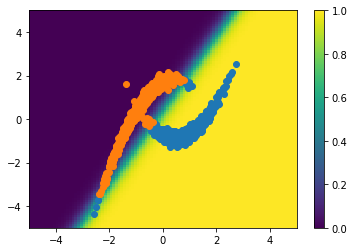

In [ ]:
xy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))

pred = linear_forward(get_params(opt_state)[0], data)
plt.scatter(*data[np.where(pred > 0)].T, zorder = 5)
plt.scatter(*data[np.where(pred < 0)].T, zorder = 5)
c = plt.pcolor(xy[0], xy[1], sigmoid(linear_forward(get_params(opt_state)[0], np.array(xy).transpose((1,2,0)).reshape(-1, 2)).reshape(xy[0].shape)))
plt.colorbar(c)

In [ ]:
def generate_sample(params, key):
    mu, log_std = params
    X, y = batch
    flat_mu, unravel = ravel_pytree(mu)
    # flatten the list to tuple
    flat_log_std,_ = ravel_pytree(log_std)
    sample = flat_mu + np.exp(flat_log_std) * random.normal(key, flat_mu.shape)
    return unravel(sample)

Average of 10 samples from posterior.

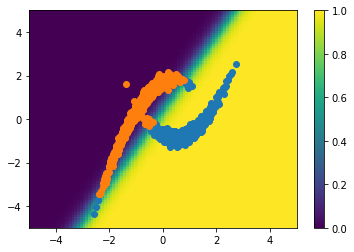

In [ ]:
linear_sample = vmap(generate_sample, in_axes=[None, 0])(get_params(opt_state), random.split(random.PRNGKey(1), 10))
linear_post_result = sigmoid(vmap(linear_forward, in_axes=(0, None))(linear_sample, np.array(xy).transpose((1,2,0)).reshape(-1, 2)).reshape((10, *xy[0].shape))).mean(0)
plt.scatter(*data[np.where(pred > 0)].T, zorder = 5)
plt.scatter(*data[np.where(pred < 0)].T, zorder = 5)
c = plt.pcolor(xy[0], xy[1], linear_post_result)
plt.colorbar(c)

In [ ]:
def NN_forward(params, X):
    w1, b1, w2, b2 = params
    out = np.tanh(X @ w1 + b1)
    out = out @ w2 + b2
    return out.reshape(-1)

def single_elbo(params, batch, rng_key):
    mu, log_std = params
    X, y = batch
    flat_mu, unravel = ravel_pytree(mu)
    flat_log_std,_ = ravel_pytree(log_std)

    flat_par = flat_mu + np.exp(flat_log_std) * random.normal(rng_key, flat_mu.shape)
    params = unravel(flat_par)
    logit_prob = NN_forward(params, X)
    prob_pres = log_sigmoid(logit_prob)
    prob_abs = log_sigmoid(-logit_prob)
    log_likelihood = np.sum(y * prob_pres + (1 - y) * prob_abs)
    log_prior = np.sum(flat_par)
    entropy = -np.sum(flat_log_std)
    return entropy - (log_likelihood + log_prior) 
def elbo(params, batch, rng_key):
    # Average over a batch of random samples.
    rng_keyes = random.split(rng_key, 20)
    loss = vmap(single_elbo, in_axes=(None, None, 0))(params, batch, rng_keyes)

    return np.mean(loss)
@jit
def step(i, opt_state, batch, rng_key):
    params = get_params(opt_state)
    g = grad(elbo)(params, batch, rng_key)
    return opt_update(i, g, opt_state)

In [ ]:
opt_state = opt_init(((np.zeros((2, 10)), np.zeros((10, )), np.zeros((10, 1)), np.zeros((1, ))), (np.zeros((2, 10)), np.zeros((10, )), np.zeros((10, 1)), np.zeros((1, )))))
pbar = trange(5000)
for i in pbar:
    rng_key = random.PRNGKey(i)
    opt_state = step(i, opt_state, batch, rng_key)

    if i % 50 == 0:
        loss_value = elbo(get_params(opt_state), batch, random.PRNGKey(0))
        pbar.set_postfix({'Loss': loss_value})


100%|██████████| 5000/5000 [00:21<00:00, 233.67it/s, Loss=-156.22917]


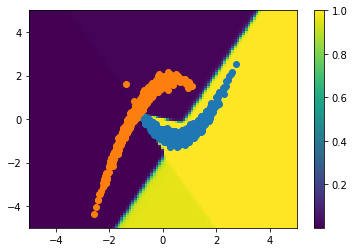

In [ ]:
xy = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))

pred = NN_forward(get_params(opt_state)[0], data)
plt.scatter(*data[np.where(pred > 0)].T, zorder = 5)
plt.scatter(*data[np.where(pred < 0)].T, zorder = 5)
c = plt.pcolor(xy[0], xy[1], sigmoid(NN_forward(get_params(opt_state)[0], np.array(xy).transpose((1,2,0)).reshape(-1, 2)).reshape(xy[0].shape)))
plt.colorbar(c)

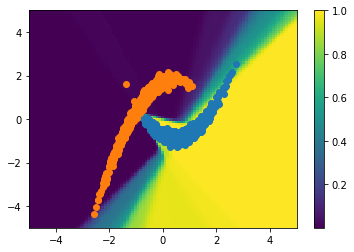

In [ ]:
NN_sample = vmap(generate_sample, in_axes=[None, 0])(get_params(opt_state), random.split(random.PRNGKey(1), 10))
NN_post_result = sigmoid(vmap(NN_forward, in_axes=(0, None))(NN_sample, np.array(xy).transpose((1,2,0)).reshape(-1, 2)).reshape((10, *xy[0].shape))).mean(0)
plt.scatter(*data[np.where(pred > 0)].T, zorder = 5)
plt.scatter(*data[np.where(pred < 0)].T, zorder = 5)
c = plt.pcolor(xy[0], xy[1], NN_post_result)
plt.colorbar(c)

### Problem 4

The analytical mean and variance are $55, 850$

Rejection Sampling

In [ ]:
def p(x):
        return (norm.pdf(x, loc=30, scale=10) + norm.pdf(x, loc=80, scale=20)) / 2
    
def q(x):
    return norm.pdf(x, loc=50, scale=30)

In [ ]:
x = np.arange(-50, 151)
k = max(p(x) / q(x))
samples = []

for i in trange(10000):
    z = onp.random.normal(50, 30)
    u = onp.random.uniform(0, k*q(z))

    if u <= p(z):
        samples.append(z)

samples = np.array(samples)

100%|██████████| 10000/10000 [01:42<00:00, 97.95it/s]


In [ ]:
print(f'The estimated mean and variances are {samples.mean().item(), samples.std().item() ** 2}')

The estimated mean and variances are (55.496089935302734, 878.3658495256677)


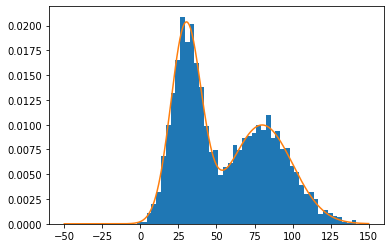

In [ ]:
plt.hist(samples, density = True, bins = 50)
plt.plot(x, p(x))

Importance sampling

In [ ]:
z = onp.random.uniform(size = 1000000, low = -40, high = 120)
mu_est = onp.mean(z * p(z) * 160)
var_est = onp.mean(z ** 2* p(z) * 160 - mu_est**2)
print(f'The estimated mean and variances are {mu_est, var_est}')

The estimated mean and variances are (DeviceArray(53.492092, dtype=float32), DeviceArray(846.9054, dtype=float32))


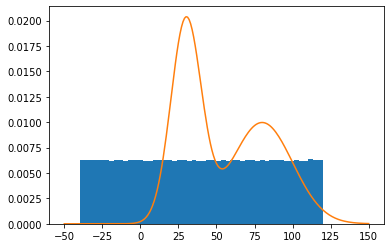

In [ ]:
plt.hist(z, density = True, bins = 50)
plt.plot(x, p(x))

### Problem 5

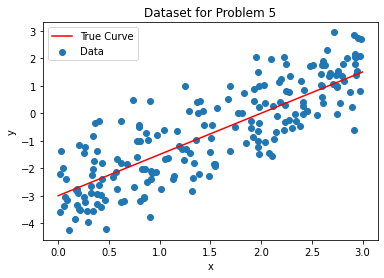

In [ ]:
# True Parameters
alpha_true = 1.5
beta_true = -3.0
gamma_true = 1
x_min = 0
x_max = 3
N = 200


# Data Generation
keys = random.split(random.PRNGKey(1))
xs = random.uniform(keys[0], shape=(N,), minval=x_min, maxval=x_max)
noise = random.normal(keys[1], shape=(N,))/np.sqrt(gamma_true)
ys = (alpha_true*xs) + beta_true + noise


# Visualization
plt.scatter(xs, ys, label='Data')
plt.plot(np.linspace(x_min, x_max),
         alpha_true*np.linspace(x_min, x_max) + beta_true,
         label = 'True Curve', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Dataset for Problem 5')
plt.show()

Gibbs sampling

In [ ]:
a, b, g = [0., 0., 1.]
par_stor = []
for i in trange(5000):
    key,_ = random.split(key)
    keys = random.split(key, 3)

    lam_1 = 1 + g * np.sum(xs**2)
    mu_1 = g * np.sum(xs * (ys - b)) / lam_1

    a = random.normal(key = keys[0]) * np.sqrt(1 / lam_1) + mu_1

    lam_2 = N * g + 1
    mu_2 = g * np.sum(ys - xs * a) / lam_2
    b = random.normal(key = keys[1]) * np.sqrt(1 / lam_2) + mu_2

    g = random.gamma(key = keys[2], a = N/2 + 2) / (1 + 0.5 * np.sum((ys - xs * a - b)**2))

    par_stor.append([a,b,g])

par_stor = np.array(par_stor)





100%|██████████| 5000/5000 [01:33<00:00, 53.26it/s]


In [ ]:
par_stor = par_stor[2000:]

In [ ]:
par_stor.mean(0)

DeviceArray([ 1.5373647, -3.0284505,  1.0821626], dtype=float32)

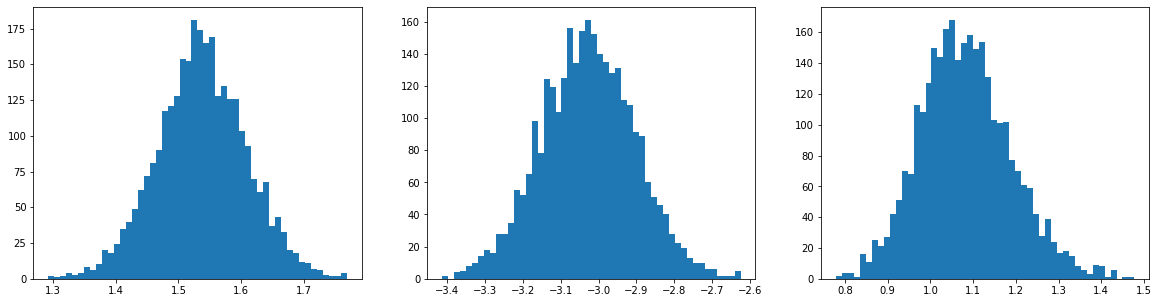

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
h = plt.hist(par_stor[:,0], bins = 50)
plt.subplot(1,3,2)
h = plt.hist(par_stor[:,1], bins = 50)
plt.subplot(1,3,3)
h = plt.hist(par_stor[:,2], bins = 50)

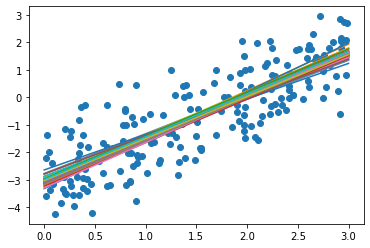

In [ ]:
plt.scatter(xs, ys, label='Data')
for i in np.arange(50) * 50:
    plt.plot(np.linspace(x_min, x_max), par_stor[i,0] * np.linspace(x_min, x_max) + par_stor[i,1])

In [ ]:
def loglikelihood(alpha, beta, gamma,data):
    xs, ys = data
    N = xs.shape[0]

    return 0.5 * N * np.log(gamma) / 2 - gamma / 2 * np.sum((ys - alpha * xs - beta) ** 2) - alpha**2 / 2 - beta**2 / 2 + np.log(gamma) - gamma





In [ ]:
key = random.PRNGKey(1)
mc_stor = []
a, b, g = [0., 0., 1.]
data = (xs, ys)
for i in trange(5000):
    key,_ = random.split(key)
    keys = random.split(key, 4)

    new_a = a + random.normal(keys[0]) * 0.25
    new_b = b + random.normal(keys[1]) * 0.25
    new_g = np.exp(np.log(g) + random.normal(keys[2]) * 0.25)

    r = np.exp(loglikelihood(new_a, new_b, new_g, data) - loglikelihood(a, b, g, data))

    if r > random.uniform(key = keys[3]):
        a = new_a
        b = new_b
        g = new_g 
    mc_stor.append([a,b,g])

mc_stor = np.array(mc_stor)




100%|██████████| 5000/5000 [02:09<00:00, 38.50it/s]


In [ ]:
mc_stor = mc_stor[2000:]

In [ ]:
mc_stor.mean(0)

DeviceArray([ 1.4868747 , -2.93378   ,  0.52947086], dtype=float32)

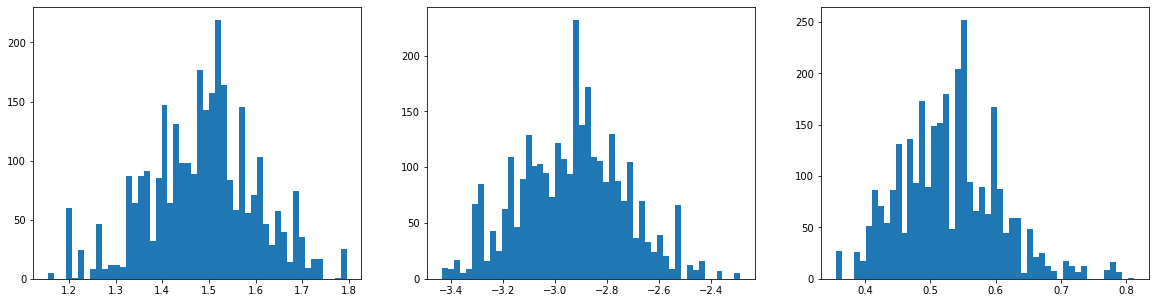

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
h = plt.hist(mc_stor[:,0], bins = 50)
plt.subplot(1,3,2)
h = plt.hist(mc_stor[:,1], bins = 50)
plt.subplot(1,3,3)
h = plt.hist(mc_stor[:,2], bins = 50)

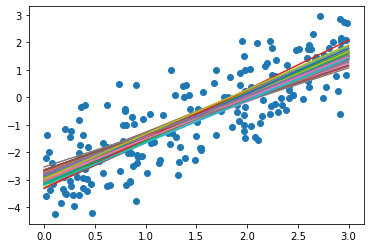

In [ ]:
plt.scatter(xs, ys, label='Data')
for i in np.arange(50) * 50:
    plt.plot(np.linspace(x_min, x_max), mc_stor[i,0] * np.linspace(x_min, x_max) + mc_stor[i,1])